# Sample Machine Learning Model using Chocolate Shop Data

This is a Jupyter style notebook, combining Python code with text describing what each step does.
* If you are viewing this on GitHub, you need to download the file and open in VSCode, Azure ML Studio or another Notebook hosting service like myBinder.org. Opening the GitHub project in a Codespace should also work.
* Each step should have an arrow beside it (left hand side), allowing you to excute that instruction.
* This notebook has sample output included for each step - if you just want to read through without executing.

The sample imports (generated) chocolate shop data from a csv file, trains a simple Naive Bayes prediction model, generates a graph showing the predictions s it would make, then exports the trained model as a PMML file we can then import into Kogito.

First, we tell pip (Pythons Package Manager) to download supporting libraries that will do the hard work for us later. This may take a minute or two the first time, but will be quicker on the next run.

In [1]:
pip install numpy matplotlib seaborn scikit-learn nyoka sklearn2pmml

Note: you may need to restart the kernel to use updated packages.


Next, we start our main Python script. We start by "importing" , which tells Python to use the packages we've just downloaded.

In [2]:

# Standard tools for manipulating numeric data
import random
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

# For Generating our Graph later.
import matplotlib.pyplot as plt

#Import Gaussian Naive Bayes model
import sklearn
from sklearn.naive_bayes import GaussianNB

# For exporting our model later
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

Now, we need to load the training data - a list of the orders for our chocolate shop. This is a standard csv (comma separated values) text file, we expect it to be in the same folder as this notebook.

**Important** - this is made up data. In real life you would need a lot more information to train an effective model.


In [3]:
# Load the information
sales_data = pd.read_csv("11_ML_learning.csv")

# print it so we can see a sample of the data we are working with
print (sales_data) 


    Order Number        Country  Customer Age  Country-Region Code  \
0              9   South Africa            64                  402   
1             14  United States            68                  103   
2             84  United States            70                  118   
3             16  United States            80                  108   
4             21  United States            77                  101   
..           ...            ...           ...                  ...   
94            93             UK            56                  198   
95            94      Sri Lanka            77                  260   
96            97      Sri Lanka            73                  253   
97            98    New Zealand            58                  230   
98            99             UK            69                  190   

    Qty Silk Tray  Qty Lumpy Bar  Qty Peanut  Qty  Main Product  
0             NaN            NaN        55.0  244  Peanut Candy  
1             NaN          

We set what features exist in the data - in our simple example we use two columns, in real life you would use many more. We set the names of each feature, as it will make the model easier to use later.

For simplicity, these values are already in numbers (e.g. we use numbers around 100 to describe locations in the US, numbers around 400 to describe locations in South Africa). The values we pass in to train our model must be numeric.

In [4]:

features = sales_data[['Customer Age' ,'Country-Region Code']]
features.columns=["Customer_Age","Country_Code"]

Labels are the values we expect in the output, given each feature. Take a look at the data we imported - for each line we have customer age, a country region code associated with the product that was bought by that customer. This helps us train the model.

In [5]:
label = sales_data["Main Product"]

This simple example is missing a step - normally we'd split our data 80:20 - 80% to train our model, keeping back 20% to test and validate how well our model is performing. The *sklearn* toolkit we're using has methods to help you do this.

Our next step is to train the model, using a Naive Bayes classifier. We wrap this training step in a (simple) one step pipeline, which makes it easier to export our model later.

In [6]:

## setup a simple PMML wraper
model = PMMLPipeline(
    [( "classifier", GaussianNB(),)]
)

# train the model using the features
model.fit(features, label)

PMMLPipeline(steps=[('classifier', GaussianNB())])

Since we've trained our model, we're going to take a look at how well it's performing. Normally we'd take the test data we held back, run it through the model and see if the predictions match what we expect.

This example does something more graphical - it generates a 1000 sample values (across a range of country codes and ages ). It makes a note of what the model predicts, in a format that will make it easy for us to graph the results.

In [7]:
lumpy_x=[]
lumpy_y=[]
peanut_x=[]
peanut_y=[]
silk_x=[]
silk_y=[]

# workaround - scikit warning that we don't have any headers on our data
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


for loop in range(1000):

    #random age and country code
    age = random.randint(0,100)
    country_code = random.randint(0,400)

    #make our prediction
    predicted= str(model.predict([[age,country_code]]))

    #set based on color
    if 'Silk' in predicted:
        silk_x.append(age)
        silk_y.append(country_code)

    #set based on color
    if 'Lumpy' in predicted:
        lumpy_x.append(age)
        lumpy_y.append(country_code)
    
    #set based on color
    if 'Peanut' in predicted:
        peanut_x.append(age)
        peanut_y.append(country_code)


Now that we have these set of 1000 predictions, let's put them on a graph. The first line allows the notebook to display a graph. The three lines in the next section plot each set of predictions on a scatter chart. Finally, we add x and y labels to make it clearer what is being shown. 

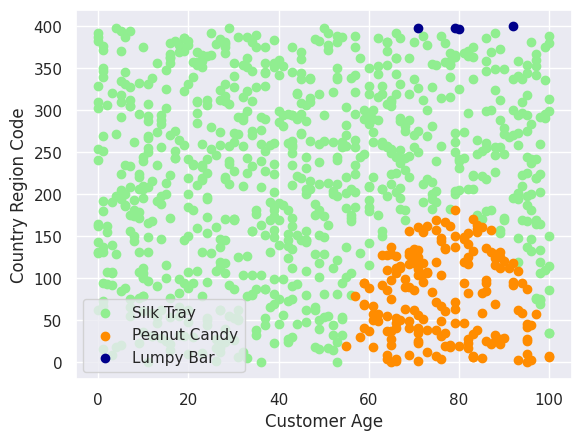

In [8]:
%matplotlib inline

plt.scatter(silk_x, silk_y, color = 'lightgreen', label='Silk Tray')
plt.scatter(peanut_x, peanut_y, color = 'darkorange', label='Peanut Candy')
plt.scatter(lumpy_x, lumpy_y, color = 'darkblue', label= 'Lumpy Bar')

plt.xlabel('Customer Age')
plt.ylabel('Country Region Code')

plt.legend(loc='lower left')


Our graph should show three key areas
1. The default recommendation, in green covering much of the graph, is that customers should buy our Silk Tray Chocolate box.
1. On the bottom right (older customers based around region 100 - the US) we recommend they buy Peanut Candy bars.
1. In a small area of the top right (older customers based in South Africa) the model should recommend they buy a Lumpy raisin chocolate bar.

If you reopen the data we originally used (in the csv file) you'll see that it is consistent with our training data. Note that we are graphing our predictions and **not** the original training data - run this notebook several times to see how our predictions change slightly each time.

Finally, we export the training model in the standard PMML format. You can open this file using a text editor, to see what is going on.

In [9]:
sklearn2pmml(model, "11_chocolate_recommendations.pmml", with_repr=True)

Important note before importing this file into a DMN Decision Model. You will need to edit the _version_ number at the very start of the file (current KIE supports version 4.3). And you need to add a _modelName_ so that the KIE sandbox can import it successfully.